# Project 1

##Carrie Garcia, Brian Mente and Trenton Manson

Our group chose to analyze police report data in our "hometown" Dallas. The City of Dallas makes municipal data available through its Open Data Portal. We chose the "Dallas_Police_Public_Data_RMS_Incidents" set.  The problems we are defining relate to the number of incidents and police response time. Insights into these relationships can help the Dallas Police Department staff appropriately and strategize for future process improvements. You can find the dataset - which is refreshed frequently - here:

https://www.dallasopendata.com/Police/Dallas-Police-Public-Data-RMS-Incidents/tbnj-w5hb 

We pulled the data for this analysis on September 12, 2015. It is an export from the record management system (RMS) that includes more than 117,000 observations and 100 attributes.

#Setup

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
plt.style.use('ggplot')
import seaborn as sns

df = pd.read_csv("Downloads/Dallas_Police_Public_Data_-_RMS_Incidents.csv") #read in the csv file

df = df.drop(['IncidentNum','ServNum','ServiceNum','ServiceNum','ServNumID', #drop unncessary columns
              'ObjAttack','RA','DPDSwornMarshalls','CompName','CompHAddress',
              'CompHApt','CompHZipCode','CompCity','CompState','CompBusName',
              'CompBAddress','SerNumLetter','Weather','RO1Badge','RO1Name',
              'RO2Badge','RO2Name','ReptOff','AssOffBadge','EleNum','FollowUp',
              'FollowUp2','SplRpt','UCRDisp','UCR1','UCR2','LatestUCR','CJIS',
              'PenalCode','OffenseCodeCC','VicPckg','UpzDate','MapDate',
              'ReviewBadgeNum'], 1)


# Always display all the columns
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

#get information about the datafile
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117562 entries, 0 to 117561
Data columns (total 64 columns):
ServYr                  117562 non-null int64
Watch                   117562 non-null object
Signal                  117121 non-null object
OffIncident             117562 non-null object
PCClass                 103322 non-null object
Premise                 117300 non-null object
Blk                     115249 non-null float64
Dir                     10944 non-null object
StrName                 115623 non-null object
Address                 116298 non-null object
AptNum                  25609 non-null object
ZipCode                 116231 non-null float64
City                    116168 non-null object
State                   115960 non-null object
PointX                  112163 non-null float64
PointY                  112163 non-null float64
Beat                    117416 non-null float64
Division                117414 non-null object
Sector                  117562 non-null i

/Users/Los_Garcia/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


# Cleaning the Data

The dataset was fairly clean to begin with. Although there were many NaN values in columns, there were few instance where apparent errors in data collection or record entries that made no sense were present. Our initial actions should be to make sure everything is properly typed in the data.

##Changing Variable Types

In [3]:
# let's start by first changing the numeric values to be floats
continuous_features = ['PointX', 'PointY','CompAge']

# we won't touch these variables, keep them as categorical
categ_features = ['Signal','OffIncident','PCClass','Premise','StrName', 
                  'Address', 'AptNum','City','State','Division','TAAG', 
                  'Community','Day1','Day2','Month1', 'Month2', 'Watch',
                  'UCROffDesc','Family','Hate','Gang','Drug',
                  'CompSex','CompRace','ServYr','Blk','ZipCode',
                    'Beat','Year1','Year2', 'Type'];

# use the "astype" function to change the variable type
df[continuous_features] = df[continuous_features].astype(np.float64)

# Changing Call Times from strings to datetime objects
df.CallOrgDate = pd.to_datetime(df.CallOrgDate, format="%m/%d/%Y %I:%M:%S %p")
df.CallReceived = pd.to_datetime(df.CallReceived,format="%m/%d/%Y %I:%M:%S %p")
df.CallCleared = pd.to_datetime(df.CallCleared, format="%m/%d/%Y %I:%M:%S %p")
df.CallDispatched = pd.to_datetime(df.CallDispatched, format="%m/%d/%Y %I:%M:%S %p")

##Calculating New Variables

We will examining the 'Response Time' between when a call was received by the DPD and when officers were dispatched to the location, but to do so we need to be able to do datetime math on the call times in each case. We'll need to change these entries to datetime objects in order to do so, then calculate the response time in minutes as a timedelta[m] datatype. 

Also, several of the visualizations we are going to examine will deal with the most frequent categories of crime in the city. For this reason, we'll create a new categorical variable called 'FreqCrimes' that contains the top five most frequent events in the reports: Theft, burglary, vandalism, auto theft, and robbery. All other incidents in this variable will be coded as "Other"

In [4]:
# Calculating Response Time from call received to units dispatched.
df['ResponseTime'] = pd.Series(data=(df.CallDispatched-df.CallReceived).astype('timedelta64[m]').astype('float'),index=df.index,name='Response Time')
df.ResponseTime.describe()

# We have 1 observation with a negative response time.  Average time to dispatch is 44 minutes. 
df[df.ResponseTime < 0]

,ServYr,Watch,Signal,OffIncident,PCClass,Premise,Blk,Dir,StrName,Address,AptNum,ZipCode,City,State,PointX,PointY,Beat,Division,Sector,District,TAAG,Community,Date1,Year1,Month1,Day1,Time1,Date1DayOfYear,Date2,Year2,...,StopDateTime,ReportedDate,EDate,EYear,EMonth,EDay,ETime,EDateDayOfYear,CallOrgDate,CallReceived,CallCleared,CallDispatched,Involvement,CompRace,CompSex,CompAge,CompAgeAtOffenseTime,Status,VictimInjuryDesc,VictimCond,OffenseCode,UCROffense,UCROffDesc,Type,MO,Family,Hate,Gang,Drug,ResponseTime
78575,2014,1,6X - MAJOR DIST (VIOLENCE),ASSAULT -OFFENSIVE CONTACT,MC,Parking Lot (All Others),4444,W,ILLINOIS AVE,4444 W ILLINOIS AVE,NaN,75211,DALLAS,TX,2462716.599468,6948773.987627,434,SouthWest,430,3,NaN,NaN,11/02/2014 12:00:00 AM,2014,November,Sun,01:04,306,11/02/2014 12:00:00 AM,2014,...,11/02/2014 01:05:00 AM,11/02/2014 12:00:00 AM,11/02/2014 12:00:00 AM,2014,November,Sun,01:12,306,2014-11-02 01:55:21,2014-11-02 01:55:20,2014-11-02 02:37:31,2014-11-02 01:04:24,Victim,L,F,40,40,Suspended,OFFENSIVE TOUCHING,Good,MC-99999999-H29,ASSAULT,ASSAULT,Part2,UNK SUSP PULLED COMP'S HAIR AND PUNCHED THE COMP,No,NaN,No,No,-51


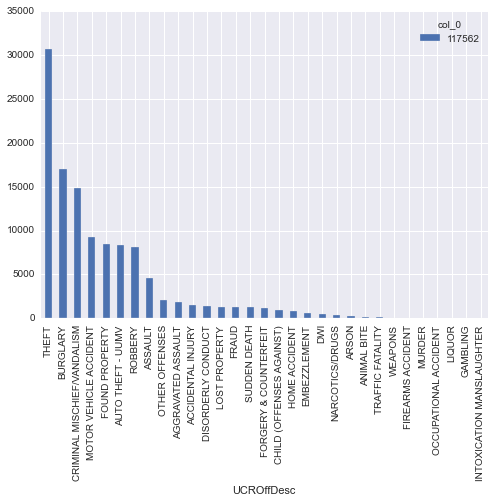

In [5]:
# Plotting most frequent UCROffDesc versus counts
df2 = pd.crosstab(df.UCROffDesc,len(df.UCROffDesc)).sort(columns=len(df.UCROffDesc),ascending=False)
df2.plot(kind='bar',sort_columns=True)

In [6]:
def func(row):
    if row['UCROffDesc'] == 'THEFT':
        return 'THEFT'
    elif row['UCROffDesc'] == 'BURGLARY':
        return 'BURGLARY' 
    elif row['UCROffDesc'] == 'CRIMINAL MISCHIEF/VANDALISM':
        return 'CRIMINAL MISCHIEF/VANDALISM' 
    elif row['UCROffDesc'] == 'AUTO THEFT - UUMV':
        return 'AUTO THEFT - UUMV'
    elif row['UCROffDesc'] == 'ROBBERY':
        return 'ROBBERY' 
    else:
        return 'OTHER'

df['FreqCrimes'] = df.apply(func, axis=1)
df['FreqCrimes'].describe()

count     117562
unique         6
top        OTHER
freq       38486
Name: FreqCrimes, dtype: object

In [9]:
# Coding Binary ArrestMade variable  
def func2(row):
    if row['Status'] == 'Clear by Arrest':
        return 1
    elif row['Status'] == 'Clear by Exceptional Arrest':
        return 1 
    else:
        return 0

df['ArrestMade'] = df.apply(func2, axis=1)

##Checking For Errors and Outliers and Conducting Data Cleaning

This is the summary for the code in this section of the notebook.

ResponseTime: Once the response time is calculated, a quick check of the values to make sure there is nothing outside the range of expectation. The mean response time is 45 minutes, but the range is from -51 minutes - which is impossible - to 1463 minutes, which is just over 24 hours. The -51 minute response time, and the 1463 minute response time, both appear to be data collection errors and the records will be dropped.

Complainant Age: The Complainant Age field had 3 entries that either made little sense or were not possible: 0, 934, and 950. In the case of the 0 age, investiagtion revealed that that value came from a single record that was an abandoned property incident where no complainant existed, but their age was entered as 0. For this reason the value was change to NaN. The two ages of over 900 were less clear, there appears to be other information about the complainant that would lead us to believe a real person existed for this record. Since we can't know what age was meant by these entries, we will impute these two records to the median age of the entire data, 37.0.

Complainant Race: Two entries in this dataset had a race of 'TEST'. Since we can not know what value the complainants race was in these case, we will change these to NaN.


PointX and PointY:  The values of both of these variables are difficult to verify, we were unable to find exactly what coordinate system these are based on.  In order to determine there are no obvious erroneous values, however, a hexbin graph was created and examined.  If the coordinates are valid, the resulting graph should roughly be in the shape of the city. Any points that are far outside the city limits should examined to ensure that they are correct. 

In [5]:
df['CompAge'].unique()

array([  nan,   27.,   22.,   65.,   41.,   42.,   60.,   37.,   33.,
         48.,   43.,   35.,   24.,   64.,   40.,   21.,   67.,   56.,
         51.,   19.,   46.,   71.,   39.,   63.,   61.,   28.,   26.,
         72.,   38.,   54.,   29.,   44.,   47.,   32.,   59.,   52.,
         25.,   50.,   23.,   73.,   58.,   31.,   53.,   49.,   30.,
         57.,   45.,   80.,   20.,   62.,   34.,   55.,   18.,   68.,
         77.,   36.,   88.,   69.,   66.,   76.,   17.,   95.,   75.,
         90.,   74.,   79.,   70.,   86.,   82.,   84.,   83.,   87.,
         81.,   99.,   91.,   78.,   93.,   92.,   96.,   85.,   89.,
         98.,   94.,  101.,   97.,  107.,  103.,  106.,  105.,  102.,
        934.,    0.,  950.,  100.])

In [6]:
# Clean up operations.
df = df.replace(to_replace={'CompAge':{934:df['CompAge'].mean()}})
df = df.replace(to_replace={'CompAge':{950:df['CompAge'].mean()}})
df = df.replace(to_replace={'CompAgeAtOffenseTime':{934:df['CompAgeAtOffenseTime'].mean()}})
df = df.replace(to_replace={'CompAgeAtOffenseTime':{950:df['CompAgeAtOffenseTime'].mean()}})
df = df.replace(to_replace={'CompAge':{0:np.nan}})

In [7]:
df['ResponseTime'].describe() #what does ResponseTime look like?

count    117109.000000
mean         44.956827
std          80.836385
min         -51.000000
25%           3.000000
50%          13.000000
75%          51.000000
max        1463.000000
Name: ResponseTime, dtype: float64

In [8]:
#examining records for ResponseTimes less than 0 and greater than 1400
df[(df.ResponseTime<0)|(df.ResponseTime>1400.0)]

,ServYr,Watch,Signal,OffIncident,PCClass,Premise,Blk,Dir,StrName,Address,AptNum,ZipCode,City,State,PointX,PointY,Beat,Division,Sector,District,TAAG,Community,Date1,Year1,Month1,Day1,Time1,Date1DayOfYear,Date2,Year2,...,ReportedDate,EDate,EYear,EMonth,EDay,ETime,EDateDayOfYear,CallOrgDate,CallReceived,CallCleared,CallDispatched,Involvement,CompRace,CompSex,CompAge,CompAgeAtOffenseTime,Status,VictimInjuryDesc,VictimCond,OffenseCode,UCROffense,UCROffDesc,Type,MO,Family,Hate,Gang,Drug,ResponseTime,FreqCrimes
8383,2015,1,31 - CRIMINAL MISCHIEF,"CRIM MISCHIEF > OR EQUAL $500 BUT < $1,500",MA,Business Office,3114,NaN,MAIN ST,3114 MAIN ST,NaN,75226,DALLAS,TX,2497458.248388,6972753.849849,153,Central,150,2,Monument Good Latimer+,NaN,08/08/2015 12:00:00 AM,2015,August,Sat,20:00,220,08/09/2015 12:00:00 AM,2015,...,08/11/2015 12:00:00 AM,08/11/2015 12:00:00 AM,2015,August,Tue,14:39,223,2015-08-10 14:18:20,2015-08-10 14:18:09,2015-08-11 15:29:31,2015-08-11 14:16:34,Victim,NaN,NaN,NaN,NaN,Suspended,NaN,NaN,MA-29990002-L25,VANDALISM & CRIM MISCHIEF,CRIMINAL MISCHIEF/VANDALISM,PART2,COMP'S WINDOW BROKEN,No,NaN,No,UNK,1438,CRIMINAL MISCHIEF/VANDALISM
78575,2014,1,6X - MAJOR DIST (VIOLENCE),ASSAULT -OFFENSIVE CONTACT,MC,Parking Lot (All Others),4444,W,ILLINOIS AVE,4444 W ILLINOIS AVE,NaN,75211,DALLAS,TX,2462716.599468,6948773.987627,434,SouthWest,430,3,NaN,NaN,11/02/2014 12:00:00 AM,2014,November,Sun,01:04,306,11/02/2014 12:00:00 AM,2014,...,11/02/2014 12:00:00 AM,11/02/2014 12:00:00 AM,2014,November,Sun,01:12,306,2014-11-02 01:55:21,2014-11-02 01:55:20,2014-11-02 02:37:31,2014-11-02 01:04:24,Victim,L,F,40,40,Suspended,OFFENSIVE TOUCHING,Good,MC-99999999-H29,ASSAULT,ASSAULT,Part2,UNK SUSP PULLED COMP'S HAIR AND PUNCHED THE COMP,No,NaN,No,No,-51,OTHER
102875,2014,1,07 - MINOR ACCIDENT,ACCIDENT INV DAMAGE TO VEHICLE,MB,"Highway, Street, Alley ETC",900,NaN,BARRY,900 BARRY,NaN,75223,DALLAS,TX,NaN,NaN,115,Central,110,NaN,NaN,NaN,07/28/2014 12:00:00 AM,2014,July,Mon,00:38,209,07/28/2014 12:00:00 AM,2014,...,07/28/2014 12:00:00 AM,07/29/2014 12:00:00 AM,2014,July,Tue,05:19,210,2014-07-27 00:38:03,2014-07-27 00:38:03,2014-07-29 06:13:02,2014-07-28 01:01:15,Victim,L,M,24,24,Suspended,NaN,Good,MB-54010010-V1,ACCIDENT MV,MOTOR VEHICLE ACCIDENT,PART2,NaN,No,NaN,No,No,1463,OTHER


In [9]:
# Dropping records with ResponseTime>1400 and <0 records
df = df[df.ResponseTime != -51]
df = df[df.ResponseTime != 1463]
df = df[df.ResponseTime != 1438]

In [10]:
# Checking to see the effect on ResponseTime of removing the two questionable records.
df.ResponseTime.describe()

count    117106.000000
mean         44.933641
std          80.627954
min           0.000000
25%           3.000000
50%          13.000000
75%          51.000000
max        1369.000000
Name: ResponseTime, dtype: float64

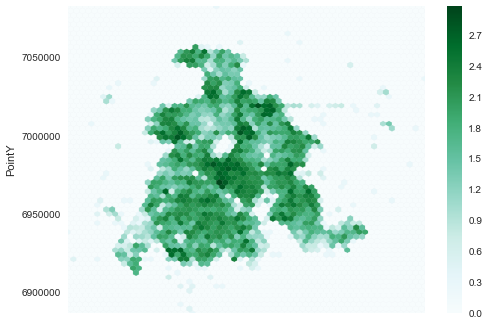

In [30]:
# Check of PointX and PointY with a hexbin graph, to determine if points roughly mirror the shape of the city of Dallas.
df.plot(kind='hexbin', bins='log', x='PointX', y='PointY',gridsize=60)

The graph above does in fact mirror the shape of the city of Dallas.  The hole in the middle of the city is correct, that sector is Highland Park, which has it's own police force and jurisdiction.  It's expected that no incident calls would be in the that ares of the city.  Also expected is the chunk missing from the Southeastern section of the city, where the Trinity River expands into the Trinity Wetlands.  This area of parks has a much lower population density, and few calls that occur within it.  

## Summary of Data Cleaning and Selected Attributes

We are using the following attributes for this analysis (simple statistics available in next section):

Number of Incidents - This is the length of the dataset.

Response Time (ResponseTime)- Created from existing data by subtracting CallReceived from CallDispatched. This is a float.

Day of the Week (Day1) - Options are Sun, Mon . . . Sat. This is a string.

Call Received (CallReceived) - Originally uploaded as a string, this has been converted to a date/time object. 

Month of the Year (Month1) - Options are January, February . . . December. This is a string.

X Coordinate (PointX) - This is latitude. This is a string we converted to a float.

Y Coordinate (PointY)- This is longitude. This is a string we converted to a float.

Crime Description (UCROffDesc) - Describes the incident reported (i.e. motor vehicle accident, theft, etc.). This is a string.

Frequent Type of Crime (FreqCrimes) - Created from UCROffDesc and contains the top five most frequent events in the reports: Theft, burglary, vandalism, auto theft, and robbery. All other incidents in this variable will be coded as "Other"

Arrest Made - Categorical variable created from status, indicates if a suspect was arrested in connection to the incident. This is a binary variable, 1 means a suspect was arrested.


In [11]:
#view the attributes we are interested in
df[['PointX','PointY','CallReceived','Month1','Day1','ResponseTime','FreqCrimes','UCROffDesc',]]

,PointX,PointY,CallReceived,Month1,Day1,ResponseTime,FreqCrimes,UCROffDesc
0,2518554.843609,6956312.372005,2015-09-11 23:57:32,September,Sat,0,OTHER,FOUND PROPERTY
1,2510170.137785,6964579.867455,2015-09-11 20:37:26,September,Fri,4,OTHER,FOUND PROPERTY
2,2468149.477886,6991039.919647,2015-09-11 20:18:25,September,Fri,1,OTHER,ASSAULT
3,2483568.791661,6936538.753386,2015-09-11 18:30:48,September,Fri,0,THEFT,THEFT
4,2466750.347141,6952366.005344,2015-09-11 18:25:02,September,Fri,55,OTHER,CHILD (OFFENSES AGAINST)
5,2482407.228369,6970221.301083,2015-09-11 20:10:47,September,Fri,83,OTHER,MOTOR VEHICLE ACCIDENT
6,2481016.461188,7049837.281561,2015-09-11 19:56:43,September,Fri,4,OTHER,ACCIDENTAL INJURY
7,NaN,NaN,2015-09-11 19:33:25,September,Fri,0,THEFT,THEFT
8,2501267.078747,6928439.210334,2015-09-11 18:44:48,September,Fri,24,OTHER,ASSAULT
9,2521867.549269,6950676.352666,2015-09-11 19:25:16,September,Fri,0,OTHER,FOUND PROPERTY


#Simple Statistics

The variables of focus are explained in more detail below with simple statistics. The total number of incidents between 2014-05-29 15:59:45 and 2015-09-11 23:57:32 is 117,559 after we remove the records we suspect of data entry errors that created significant outliers for the ResponseTime variable. We have 112,148 records that also have latitude and longitude points associated with them (aka Points X and Y). The average response time is 44.9 minutes, with a standard deviation of 80.6 minutes. After data cleansing, the minimum ResponseTime value is 0 minutes and the maximum is 1,369 minutes. The variable in highly skewed positive. More than 26 percent of the reported incidents in this dataset are theft, 14.5% for burglary, 12.7% for criminal mischief/vandalism, 7% auto theft, 7% robbery and 32.7% categorized as other. 

##Number of Incidents

In [12]:
#number of incidents (rows) in the dataframe
len(df.index)

117559

##Points X and Y

In [13]:
continuous_features = ['PointX','PointY']
series_mean = df[continuous_features].mean()
series_median = df[categ_features].median()
cat_series = pd.concat((series_median,series_mean))
df[continuous_features].describe()

,PointX,PointY
count,112161.000000,112161.000000
mean,2494712.946920,6978175.676401
std,22685.785688,31545.947092
min,2411659.219113,6886689.142861
25%,2477204.860598,6954533.621451
50%,2493388.308083,6976100.025211
75%,2508871.964970,7001934.929192
max,2595095.191828,7083051.084722


##Response Time

In [14]:
# Response time is caluclated in minutes, and defined as the time between the call 
# being received and the officers being dispatched to the incident.
df.ResponseTime.describe()

count    117106.000000
mean         44.933641
std          80.627954
min           0.000000
25%           3.000000
50%          13.000000
75%          51.000000
max        1369.000000
Name: ResponseTime, dtype: float64

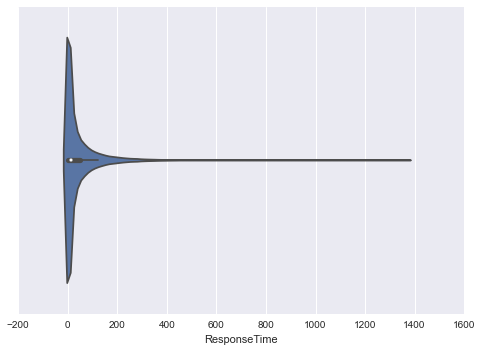

In [15]:
ax = sns.violinplot(x=df.ResponseTime)

##Types of Crimes

In [16]:
#summary of frequently occuring types of crimes
df['FreqCrimes'].describe()

count     117559
unique         6
top        OTHER
freq       38484
Name: FreqCrimes, dtype: object

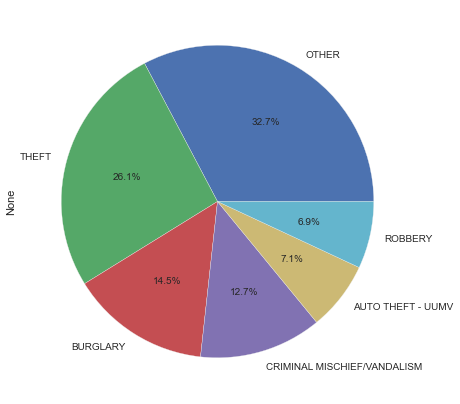

In [17]:
#showing the percentage of each frequently occuring type of crime
df['FreqCrimes'].value_counts()
crime_counts = df['FreqCrimes'].value_counts()
crime_counts[:6].plot(kind='pie',figsize=(7,7),autopct='%1.1f%%')

##Dates and Times

In [7]:
#first and last date entries in the database
print min(df.CallReceived)
print max(df.CallReceived)

2014-05-29 15:59:45
2015-09-11 23:57:32


In [10]:
#Descriptive statistics of the categorical Arrest Made variable.
df['ArrestMade'].describe()

count    117562.000000
mean          0.102780
std           0.303672
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: ArrestMade, dtype: float64

After recoding the Status category into a binary categorical variable indicating if an arrest was made, we find that Arrests were made on roughly 10% of the incidents in the city. 

#Attribute Relationship Visualizations

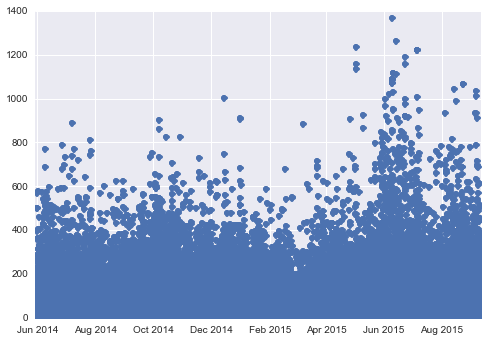

In [19]:
#showing the relationship between CallReceived date/time object and ResponseTime
plt.plot_date(df.CallReceived, df.ResponseTime, xdate=True, ydate=False)

This scatter plot gives us a good idea of where the outliers in the distribution took place.  We see that there were significantly more incidents with longer response times this summer versues last summer, for instance.

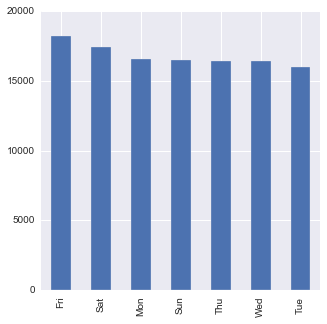

In [52]:
#plot number on incidents by days of the week by descending order
df['Day1'].value_counts()
day_counts = df.Day1.value_counts()
day_counts[:12].plot(kind='bar')

a4_dims = (18, 8)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.countplot(y="Day1", hue="FreqCrimes", data=df, order=['Sun','Mon','Tue','Wed','Thu','Fri','Sat'],);
plt.legend(loc='best')

By plotting the counts of incidents versus the day of the week, we find there does appear to be a higher frequency of events on Fridays and Saturdays than other days of the week.  When we break that down further by the crime category, we find that the biggest variation between days is the other category. A possible explaination may the inclusion of Motor Vehicle Accidents into the "Other" category, which have a higher frequency on Fridays, Saturdays, and Sundays.



In [11]:
df_past_year = df[(df.CallReceived>pd.to_datetime('09/12/2014', format="%m/%d/%Y"))]

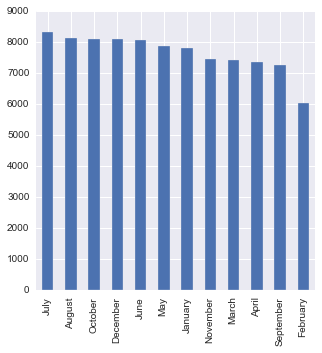

In [13]:
#plot number of incidents by months by descending order, in the last year
df_past_year['Month1'].value_counts()
month_counts = df_past_year['Month1'].value_counts()
month_counts[:12].plot(kind='bar',figsize=(5,5))

In the plot above we see incidents by month, for only the past year of data. This graph is heavily influenced by the number of days in a month.

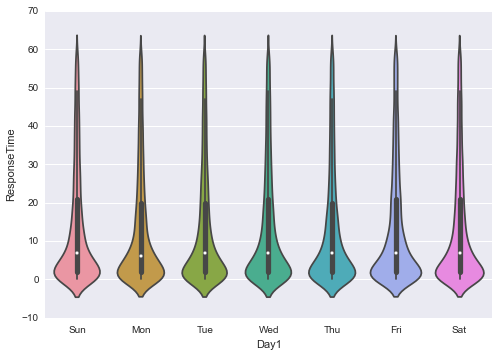

In [20]:
#investigating Response Time by Day of the Week
a4_dims = (12, 8)
fig, ax = plt.subplots(figsize=a4_dims)
ax =sns.violinplot(x=df.Day1, y=df.ResponseTime,inner="quartile", scale='count',order=['Sun','Mon','Tue','Wed','Thu','Fri','Sat'])
ax.set(ylim=(-10,100))

The violin plots above examine response times throughout the week.  The dotted lines indicate the median response time for each day of the week.  There doesn't appear to be much variation across the dataset due to the day of the week the call came in. Wednesday appears to have a slightly higher median response time by a few minutes. 



[(-10, 100)]

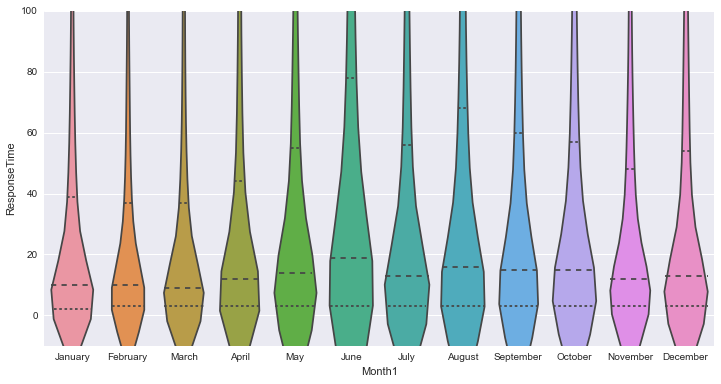

In [53]:
#investingating Response Time by Month up to 60 minutes
#changing size with source: http://stackoverflow.com/questions/31594549/how-do-i-change-the-figure-size-for-a-seaborn-violin-plot
a4_dims = (12, 6)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.violinplot(x=df.Month1, y=df.ResponseTime[(df.CallReceived>pd.to_datetime('09/12/2014', format="%m/%d/%Y"))], inner="quartile", scale='count',order=['January','February','March','April','May','June','July','August','September','October','November','December'])
ax.set(ylim=(-10,100))

There does appear to be some seasonal variation in response time, however, as shown in the violin plot above.  This may just be an artifact from this past year, but there appear to be lower median response times in the winter, and higher ones in June.  

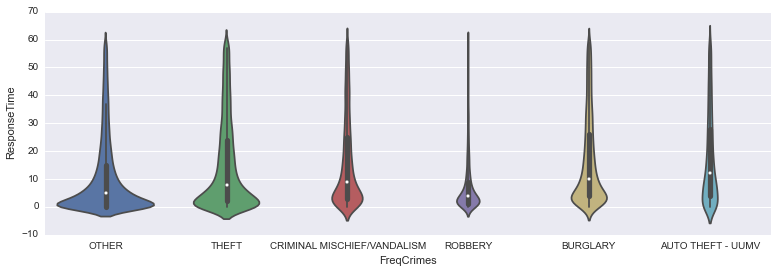

In [25]:
#investingating Response Time by Most Frequent Crimes up to 60 minutes
a4_dims = (15, 4)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.violinplot(x=df.FreqCrimes, y=df.ResponseTime,inner='quartile', order=['THEFT','BURGLARY','CRIMINAL MISCHIEF/VANDALISM','AUTO THEFT - UUMV','ROBBERY','OTHER'], scale='count')
ax.set(ylim=(-10,100))


The visualization above suggests that response times by crime seem to vary widely as well.  The median response time is similar for the top three most common crimes, very high for Auto Theft, and very low for Robberies and other crimes.

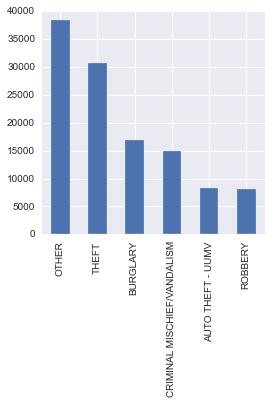

In [48]:
# plot number of incidents by frequently reported types of crime by descending order
ArrestsByCrime = pd.crosstab( df["FreqCrimes"],df["ArrestMade"],margins=True).apply(lambda r: r/r.sum()*200, axis=1)
pd.options.display.float_format = '{:.2f}%'.format
ArrestsByCrime


The bar chart above shows the number of incidents for each crime category, which visualizes information we have already seen before in this analysis as a pie chart and a table. This visualization shows in descending order to easily identify which categories have the highest number of reported incidents.

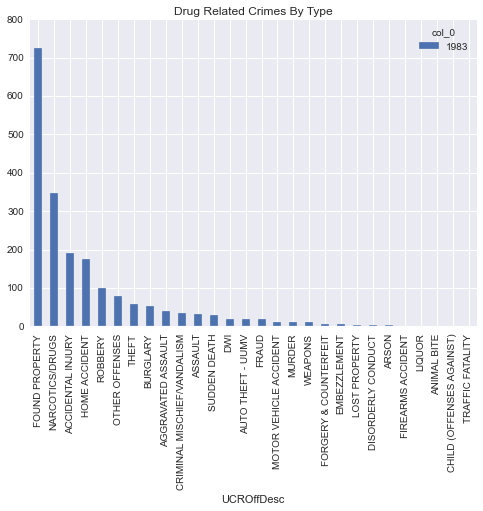

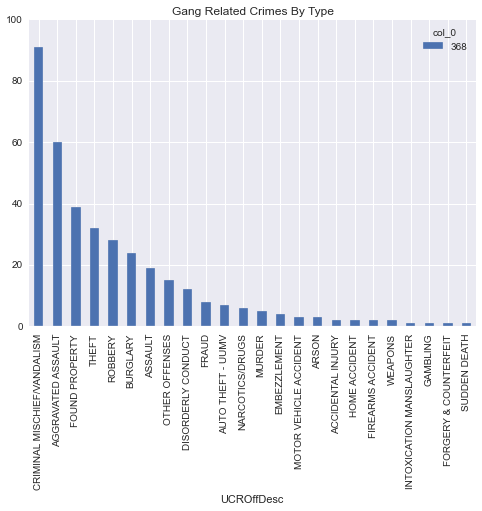

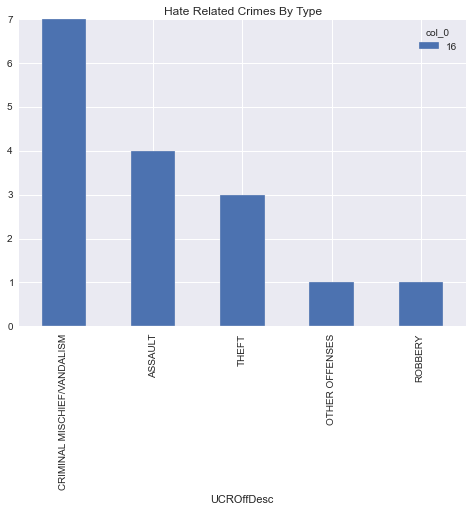

In [27]:
#Creating dataframes based on catagorical variables Gang Drug and Hate Crimes

df["Gang"]=="Yes"
gang_crimes = df[df["Gang"]=="Yes"]
df["Drug"]=="Yes"
drug_crimes = df[df["Drug"]=="Yes"]
df["Hate"]=="Yes"
hate_crimes = df[df["Hate"]=="Yes"]

# Plotting most frequent UCROffDesc versus counts for Drug Crimes
dc = pd.crosstab(drug_crimes.UCROffDesc,len(drug_crimes.UCROffDesc)).sort(columns=len(drug_crimes.UCROffDesc),ascending=False)
dc.plot(kind='bar',title="Drug Related Crimes By Type",sort_columns=True)

# Plotting most frequent UCROffDesc versus counts for Gang Crimes
gc = pd.crosstab(gang_crimes.UCROffDesc,len(gang_crimes.UCROffDesc)).sort(columns=len(gang_crimes.UCROffDesc),ascending=False)
gc.plot(kind='bar',title="Gang Related Crimes By Type",sort_columns=True)

# Plotting most frequent UCROffDesc versus counts for Hate Crimes
hc = pd.crosstab(hate_crimes.UCROffDesc,len(hate_crimes.UCROffDesc)).sort(columns=len(hate_crimes.UCROffDesc),ascending=False)
hc.plot(kind='bar',title="Hate Related Crimes By Type",sort_columns=True)

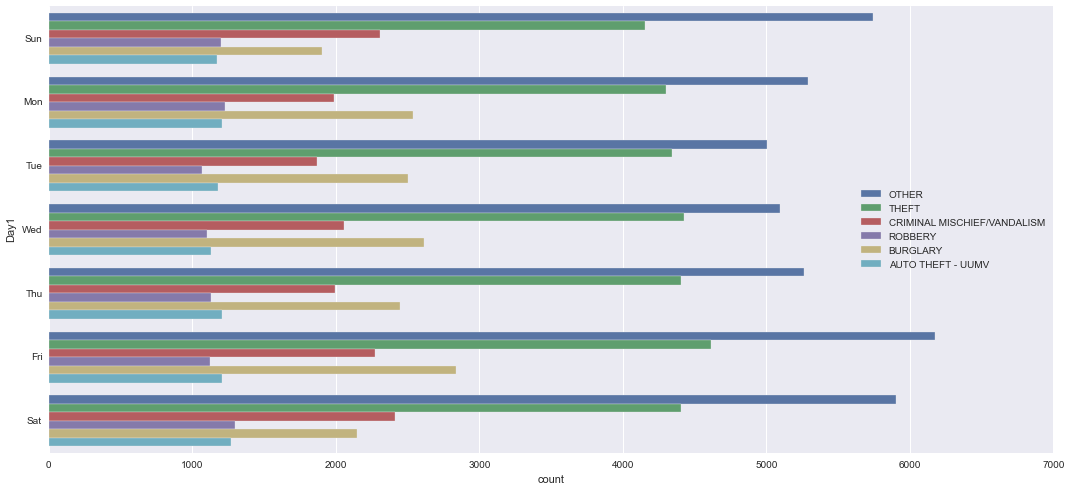

In [37]:
#Number of incidents per day and by frequent crime categories
a4_dims = (18, 8)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.countplot(y="Day1", hue="FreqCrimes", data=df, order=['Sun','Mon','Tue','Wed','Thu','Fri','Sat']);
plt.legend(loc='best')

The plot visualization above suggests a similar pattern across all days of the week for the types of crime and number of incidents.

##Geolocation and Response Time with Log Scale

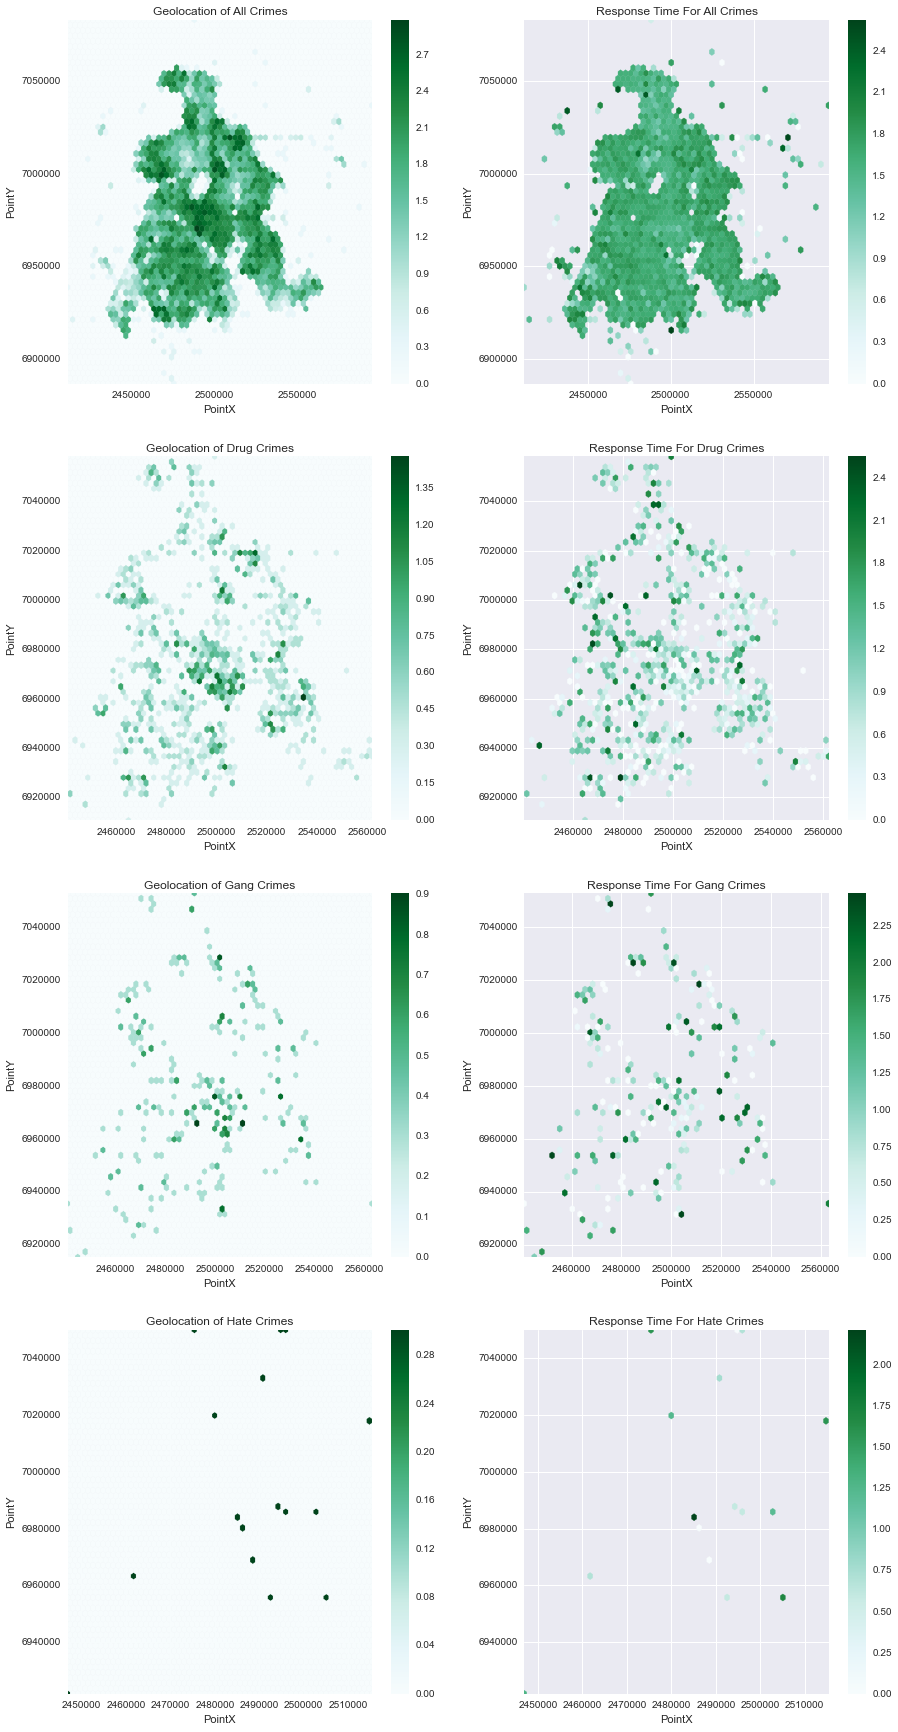

In [47]:
#Now let's put these in a nice figure as subplots
#Highland Park and University Park (who have their own police force) account for the hole in the middle of the map

plt.figure(1,figsize=(15,30))
plt.subplot(4,2,1)
df.plot(kind='hexbin', bins='log', x='PointX', y='PointY', gridsize=60,ax=plt.gca()) #no need to specify for first axis
plt.title("Geolocation of All Crimes")

plt.subplot(4,2,2)
df.plot(kind='hexbin', bins='log', x='PointX', y='PointY', C = "ResponseTime", reduce_C_function =np.mean, gridsize=60,ax=plt.gca())
plt.title("Response Time For All Crimes")

plt.subplot(4,2,3)
drug_crimes.plot(kind='hexbin', bins='log', x='PointX', y='PointY', gridsize=60,ax=plt.gca())
plt.title("Geolocation of Drug Crimes")

plt.subplot(4,2,4)
drug_crimes.plot(kind='hexbin', bins='log', x='PointX', y='PointY', C = "ResponseTime", reduce_C_function =np.mean, gridsize=60,ax=plt.gca()) 
plt.title("Response Time For Drug Crimes")

plt.subplot(4,2,5)
gang_crimes.plot(kind='hexbin', bins='log', x='PointX', y='PointY', gridsize=60,ax=plt.gca())
plt.title("Geolocation of Gang Crimes")

plt.subplot(4,2,6)
gang_crimes.plot(kind='hexbin', bins='log', x='PointX', y='PointY', C = "ResponseTime", reduce_C_function =np.mean, gridsize=60,ax=plt.gca()) 
plt.title("Response Time For Gang Crimes")

plt.subplot(4,2,7)
hx7=hate_crimes.plot(kind='hexbin', bins='log', x='PointX', y='PointY', gridsize=60,ax=plt.gca()) 
plt.title("Geolocation of Hate Crimes")

plt.subplot(4,2,8)
hate_crimes.plot(kind='hexbin', bins='log', x='PointX', y='PointY', C = "ResponseTime", reduce_C_function =np.mean, gridsize=60,ax=plt.gca())
plt.title("Response Time For Hate Crimes")

Geographically, looking at the map that includes all of Dallas, it seems that DPD already has resource alignment with the number of incidents if you compare that map with the response time map. In other words, the places that are darkest (most incidents) on the incidents map are lighter (shorter time) on the response time map indicating they are already covering those areas well. The 75 corridor also likely plays a role in this relationship, allowing the officers to arrive quickly.

These plots also suggest that most gang, hate and drug crimes occur in the downtown Dallas area. However, it is difficult to visualize a response time pattern for these crime types.

##Geolocation and Response Time without Log Scale

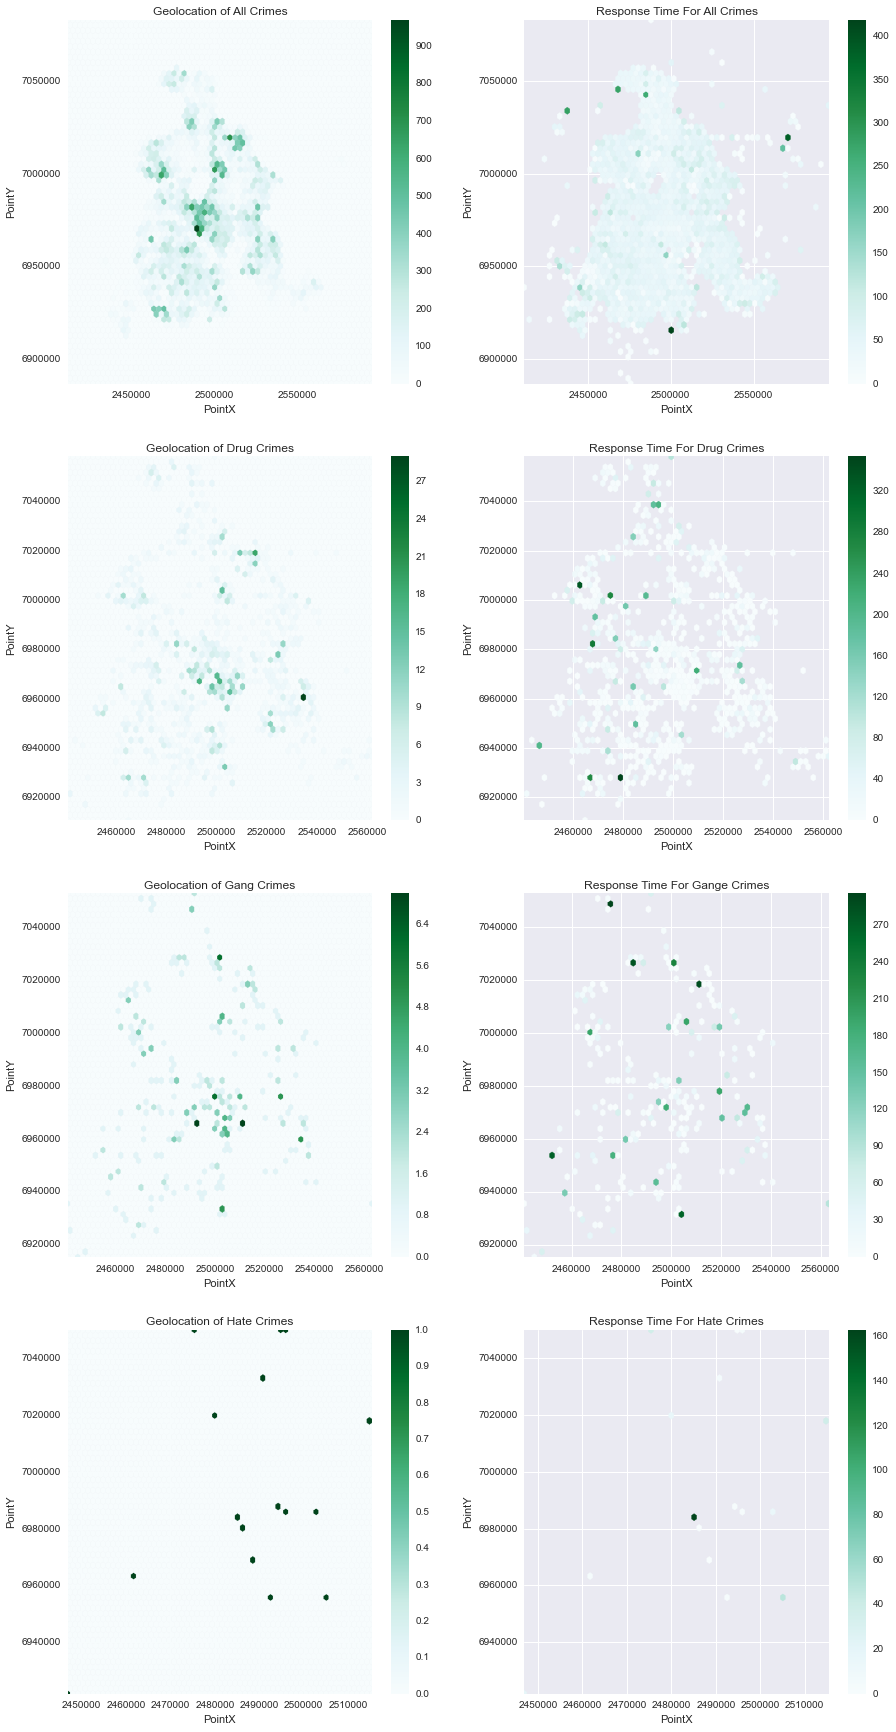

In [29]:
#Now let's put these in a nice figure as subplots

plt.figure(1,figsize=(15,30))
plt.subplot(4,2,1)
df.plot(kind='hexbin', x='PointX', y='PointY', gridsize=60,ax=plt.gca()) #no need to specify for first axis
plt.title("Geolocation of All Crimes")

plt.subplot(4,2,2)
df.plot(kind='hexbin', x='PointX', y='PointY', C = "ResponseTime", reduce_C_function =np.mean, gridsize=60,ax=plt.gca())
plt.title("Response Time For All Crimes")

plt.subplot(4,2,3)
drug_crimes.plot(kind='hexbin', x='PointX', y='PointY', gridsize=60,ax=plt.gca())
plt.title("Geolocation of Drug Crimes")

plt.subplot(4,2,4)
drug_crimes.plot(kind='hexbin', x='PointX', y='PointY', C = "ResponseTime", reduce_C_function =np.mean, gridsize=60,ax=plt.gca()) 
plt.title("Response Time For Drug Crimes")

plt.subplot(4,2,5)
gang_crimes.plot(kind='hexbin', x='PointX', y='PointY', gridsize=60,ax=plt.gca())
plt.title("Geolocation of Gang Crimes")

plt.subplot(4,2,6)
gang_crimes.plot(kind='hexbin', x='PointX', y='PointY', C = "ResponseTime", reduce_C_function =np.mean, gridsize=60,ax=plt.gca()) 
plt.title("Response Time For Gange Crimes")

plt.subplot(4,2,7)
hx7=hate_crimes.plot(kind='hexbin', x='PointX', y='PointY', gridsize=60,ax=plt.gca()) 
plt.title("Geolocation of Hate Crimes")

plt.subplot(4,2,8)
hate_crimes.plot(kind='hexbin', x='PointX', y='PointY', C = "ResponseTime", reduce_C_function =np.mean, gridsize=60,ax=plt.gca())
plt.title("Response Time For Hate Crimes")

11.0

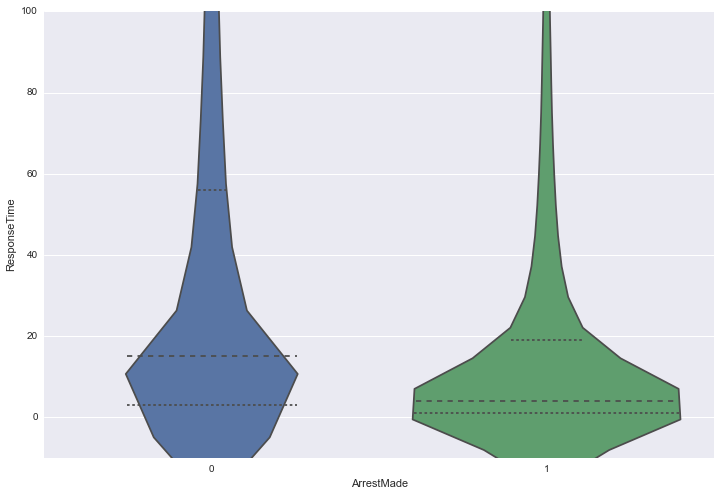

In [14]:
#plot of ResponseTime by Arrest Made - - - interesting suggested evidence here
a4_dims = (12, 8)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.violinplot(x=df.ArrestMade,y=df.ResponseTime,inner='quartile')
ax.set(ylim=(-10,100))
df.ResponseTime[(df.ArrestMade==0)].median()-df.ResponseTime[(df.ArrestMade==1)].median()

There does appear to be a relationship between Response Time and whether or not an arrest was made.  The violin plots above show the distributions and quartiles for Response Times when no arrest was made in the figure on the left, and Response Times when an arrest was made in the figure on the right.  The median response time of the incidents where an arrest was made was 11 minutes less than the incidents where no arrest was made.  The comparison of these two groups of incidents looks to be a good candidate for further statistical analysis exploring their association.

In [43]:
# plot number of incidents by frequently reported types of crime by descending order
ArrestsByCrime = pd.crosstab( df["FreqCrimes"],df["ArrestMade"],margins=True).apply(lambda r: r/r.sum()*200, axis=1)
pd.options.display.float_format = '{:.2f}%'.format
ArrestsByCrime

ArrestMade,0,1,All
FreqCrimes,,,
AUTO THEFT - UUMV,96.23%,3.77%,100.00%
BURGLARY,97.19%,2.81%,100.00%
CRIMINAL MISCHIEF/VANDALISM,95.44%,4.56%,100.00%
OTHER,83.37%,16.63%,100.00%
ROBBERY,84.75%,15.25%,100.00%
THEFT,90.33%,9.67%,100.00%
All,89.72%,10.28%,100.00%


Examining the proportions of arrests by crime in the table above reveals another interesting difference. Arrests appear to be very infrequent in cases of burglary, vandalism, and auto theft, and more frequent for Robbery, Theft, and Other Crimes. See a visualization of this table below.

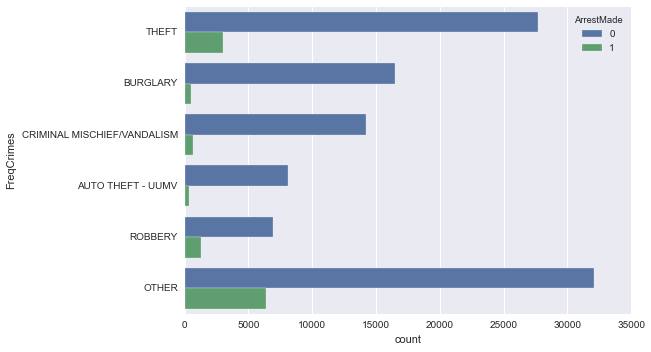

In [44]:
sns.countplot(y="FreqCrimes", hue="ArrestMade", data=df, order=['THEFT','BURGLARY','CRIMINAL MISCHIEF/VANDALISM','AUTO THEFT - UUMV','ROBBERY','OTHER']);

In [ ]:
# plot number of incidents by frequently reported types of crime by descending order
ArrestsByDow = pd.crosstab( df["Day1"],df["ArrestMade"],margins=True).apply(lambda r: r/r.sum()*200, axis=1)
pd.options.display.float_format = '{:.2f}%'.format
ArrestsByDow


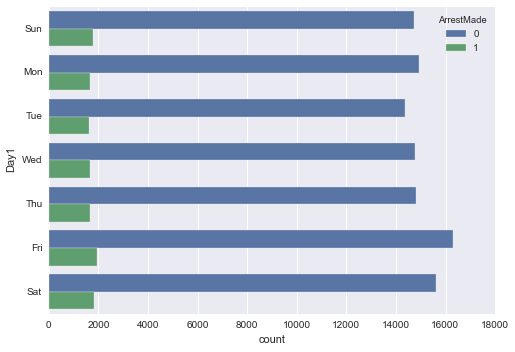

In [45]:
#Plot the relationship between days of the week and the most frequent crime types
sns.countplot(y="Day1", hue="ArrestMade", data=df, order=['Sun','Mon','Tue','Wed','Thu','Fri','Sat']);

There does not appear, however, to be a relationship between day of the week and Number of Arrests Made as seen in the visualization above. Hypothesis testing should be done to confirm.

#Conclusions